# Colorful Image Colorization

This is the notebook used for testing and experimentation for CV mid-evals. In this notebook, we will define the code used for loading the imageNet and Pascal datasets, and passing the dataloaders to run the model architecture given in the paper.

### Dataloaders

In [1]:
# import libraries

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
%matplotlib inline
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os
import time
from torchvision.datasets import ImageFolder
from matplotlib.pyplot import imshow
from skimage import color
# torch.manual_seed(101)

In [2]:
def resize_image(src, size=(256, 256), bgc="white"):
    src.thumbnail(size, Image.ANTIALIAS)
    new_image = Image.new("RGB", size, bgc)
    new_image.paste(src, (int((size[0]-src.size[0]) / 2)), int((size[1] - src.size[1]) / 2))
    new_image = color.rgb2lab(new_image)[:,:,0]
    print(new_image.shape)
    return new_image

In [3]:
transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.Grayscale(),
    transforms.ToTensor(),
])

In [4]:
def load(path):
    dataset = torchvision.datasets.ImageFolder(root=path,transform = transform)
    
    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size

    train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader

#### ImageNet

In [5]:
ImageNetTrainLoader, ImageNetTestLoader = load('../Datasets/tiny_imagenet/tiny-imagenet-200/train/')
print(f"train loaders: {ImageNetTrainLoader}")

train loaders: <torch.utils.data.dataloader.DataLoader object at 0x7f30eab9af10>


In [6]:
def plot_images(loader):
    # Get a batch of data
    data_iter = iter(loader)
    data, targets = next(data_iter)
    
    # Select 6 random images
    rand_idx = torch.randperm(data.shape[0])[:6]
    data = data[rand_idx]
    targets = targets[rand_idx]
    
    # Create a figure with 6 subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
    
    # Loop over the subplots and display the images
    for i, ax in enumerate(axes.flatten()):
        img = data[i].permute(1, 2, 0).numpy()  # Convert to a numpy array and permute dimensions to [H, W, C]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {targets[i]}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

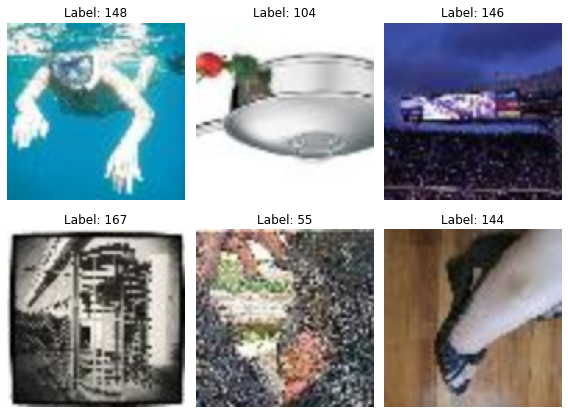

In [32]:
plot_images(ImageNetTrainLoader)

#### Pascal

In [ ]:
VOCDataset = datasets.VOCDetection('./Datasets/PASCAL_VOC', year='2012', image_set='train', download=True, transform=transform)

In [ ]:
train_size = int(0.7 * len(VOCDataset))
test_size = len(VOCDataset) - train_size

train_set, test_set = torch.utils.data.random_split(VOCDataset, [train_size, test_size])

VOCTrainLoader = torch.utils.data.DataLoader(
    train_set,
    batch_size=50,
    num_workers=0,
    shuffle=False
)

VOCTestLoader = torch.utils.data.DataLoader(
    test_set,
    batch_size=50,
    num_workers=0,
    shuffle=False
)

In [ ]:
plot_images(VOCTrainLoader)

We have now loaded the imageNet dataset with suitable processing, including resizing to appropriate sizes and converting to labspace.
The following section looks at the existing implementation of the project.

### Model Implementation

In [7]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm


class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

In [ ]:
model = ECCVGenerator()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model

train_loss = 0.0
for i, data in enumerate(ImageNetTrainLoader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    train_loss += loss.item()
    if i % 1 == 0:    # print every 100 mini-batches
        print(f"{train_loss / 100:.3f}")
        train_loss = 0.0

The above code is used for the training of the model. However, while testing, we observed that the baseline code given in the paper was not feasible for reproduction standards. The codebase given is not sufficient for an entire end-to-end implementation. 
The following aspects are given to us in the base implementation:

- Model Architecture (PyTorch)
- Image Processing Helper Functions
- Conversion to labspace

Here, however, it is important to note that the model architecture implementation is elementary considering that the architecture is well-defined. In addition, the image processing done is with rudimentary techniques, and no class rebalancing or defining of discrete buckets is done. The following aspects are missing from base implementation that are required for the pipeline:

- Data loaders for imageNet and Pascal datasets
- Generation of discrete probability space
- Definition of the defined custom loss functions
- Training, validation, and testing code
- Code for generation of any results and baseline evaluation metrics.
- Code for object detection and benchmarking with other models.

### Labspace discrete mapping

In this section we will generate the discrete 313 bins that define the labspace, more particularly the a and b components, which will map across the entire colour space. This is done by considering a 2D array of size 313x2, each having appropriate dimensions that project onto a 2D space. This array will be used further in our pipeline for training and testing of the model.

The following labspace array is obtained using existing weights available related to converting continuous colour space into discrete bins

In [14]:
# load q_ab from file
q_ab = []
with open('Helper_Data/q_ab.txt', 'r') as f:
    for line in f:
        # read line and split on whitespace
        q_ab.append([int(x) for x in line.split()])
q_ab = np.array(q_ab)
print(q_ab)

# output q_ab to a file
with open('Helper_Data/q_ab.txt', 'w') as f:
    for item in q_ab:
        # write item to file with fstrings
        f.write(f"{item[0]} {item[1]}\n")


[[ -90   50]
 [ -90   60]
 [ -90   70]
 [ -90   80]
 [ -90   90]
 [ -80   20]
 [ -80   30]
 [ -80   40]
 [ -80   50]
 [ -80   60]
 [ -80   70]
 [ -80   80]
 [ -80   90]
 [ -70    0]
 [ -70   10]
 [ -70   20]
 [ -70   30]
 [ -70   40]
 [ -70   50]
 [ -70   60]
 [ -70   70]
 [ -70   80]
 [ -70   90]
 [ -60  -20]
 [ -60  -10]
 [ -60    0]
 [ -60   10]
 [ -60   20]
 [ -60   30]
 [ -60   40]
 [ -60   50]
 [ -60   60]
 [ -60   70]
 [ -60   80]
 [ -60   90]
 [ -50  -30]
 [ -50  -20]
 [ -50  -10]
 [ -50    0]
 [ -50   10]
 [ -50   20]
 [ -50   30]
 [ -50   40]
 [ -50   50]
 [ -50   60]
 [ -50   70]
 [ -50   80]
 [ -50   90]
 [ -50  100]
 [ -40  -40]
 [ -40  -30]
 [ -40  -20]
 [ -40  -10]
 [ -40    0]
 [ -40   10]
 [ -40   20]
 [ -40   30]
 [ -40   40]
 [ -40   50]
 [ -40   60]
 [ -40   70]
 [ -40   80]
 [ -40   90]
 [ -40  100]
 [ -30  -50]
 [ -30  -40]
 [ -30  -30]
 [ -30  -20]
 [ -30  -10]
 [ -30    0]
 [ -30   10]
 [ -30   20]
 [ -30   30]
 [ -30   40]
 [ -30   50]
 [ -30   60]
 [ -30   70]